In [1]:
import numpy as np
import pandas as pd
import os
import glob
import random
import matplotlib.pyplot as plt

In [2]:
# Assuming the dataset has been extracted and the path is set accordingly
data_path = '/home/ha/Downloads/release_gp_homework_data/OceanFlow/'

# Initialize lists to hold the magnitudes for each time step
us = []
vs = []
magnitudes = []

# Load all the time steps (from 1 to 100)
for i in range(1, 101):
    u_file = os.path.join(data_path, f"{i}u.csv")
    v_file = os.path.join(data_path, f"{i}v.csv")
    
    u = pd.read_csv(u_file, header=None).values
    v = pd.read_csv(v_file, header=None).values
    
    magnitude = np.sqrt(u**2 + v**2)
    us.append(u)
    vs.append(v)
    magnitudes.append(magnitude)

In [3]:
# Stack magnitudes to create a 3D array: (time, y, x)
magnitudes = np.array(magnitudes)
us = np.array(us)
vs = np.array(vs)

# Calculate the variance across time for each (y, x) location
variance = np.var(magnitudes, axis=0)

# Filter out locations with zero variance
variance[variance == 0] = np.nan

# Find the index of the minimum non-zero variance
min_variance_index = np.nanargmin(variance)
min_variance_value = np.nanmin(variance)

# Convert the flat index back to 2D indices (y, x)
min_y, min_x = np.unravel_index(min_variance_index, variance.shape)

# Convert to kilometers
min_x_km = min_x * 3
min_y_km = min_y * 3

(min_x_km, min_y_km, min_variance_value)


(510, 363, 1.2297629738694259e-13)

In [4]:
magnitudes.shape

(100, 504, 555)

In [5]:
variance.shape

(504, 555)

In [6]:
# Initialize variables to track the maximum value and its location
max_u_value = -np.inf
max_time_index = None
max_y_index = None
max_x_index = None

# Iterate through all time steps
i = 0
for u in us:
    # Find the maximum value in this u array
    current_max = np.max(u)
    
    if current_max > max_u_value:
        max_u_value = current_max
        max_time_index = i
        max_y_index, max_x_index = np.unravel_index(np.argmax(u), u.shape)
    
    i+=1

# Convert the indices to kilometers and hours
max_time_hours = max_time_index * 3
max_x_km = max_x_index * 3
max_y_km = max_y_index * 3

(max_time_hours, max_x_km, max_y_km)


(84, 1041, 543)

# Two areas with high correlation

In [7]:
# Initialize accumulators for the sum of u and v components
u_sum = 0.0
v_sum = 0.0
total_points = 0

# Iterate through all time steps
for i in range(len(us)):
    u = us[i]
    v = vs[i]
    # Accumulate the sums
    u_sum += np.sum(u)
    v_sum += np.sum(v)
    
    # Count total points (assumes all u and v files have the same dimensions)
    total_points += u.size

# Compute the average
u_avg = u_sum / total_points
v_avg = v_sum / total_points

(u_avg, v_avg)


(-0.09366228934616819, -0.035483887388106795)

To efficiently find correlations, we will randomly select a subset of points (e.g., 1000 points). We can then compute the correlation coefficients between pairs of these points.

To compute the correlations, we'll consider the following:

+ Compute the correlation coefficient for the u component (horizontal flow) and the v component (vertical flow) for each pair of points over time.
+ Combine these correlations to get an overall correlation metric (e.g., average or maximum correlation).

In [8]:
# Randomly sample a set of points to check correlations
num_samples = 500  # Example: sample 1000 points
max_x, max_y = us.shape[2], us.shape[1]

sample_points = [(random.randint(0, max_y-1), random.randint(0, max_x-1)) for _ in range(num_samples)]

# Compute the correlation between randomly sampled pairs
correlations = []

for i in range(num_samples):
    for j in range(i+1, num_samples):
        point1 = sample_points[i]
        point2 = sample_points[j]
        
        # Extract the time series data for each point
        u1 = us[:, point1[0], point1[1]]
        v1 = vs[:, point1[0], point1[1]]
        u2 = us[:, point2[0], point2[1]]
        v2 = vs[:, point2[0], point2[1]]
        
        # Compute correlations
        corr_u = np.corrcoef(u1, u2)[0, 1]
        corr_v = np.corrcoef(v1, v2)[0, 1]
        
        # Combine correlations (here we use maximum correlation)
        combined_corr = max(corr_u, corr_v)
        
        correlations.append((combined_corr, point1, point2))

/home/ha/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ha/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


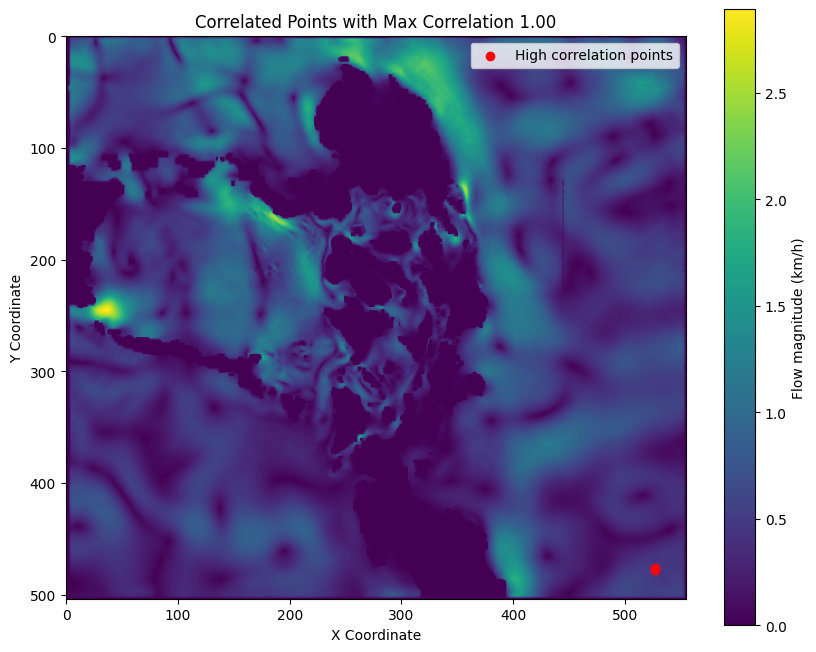

In [13]:
# Filter for high correlations
high_corr_threshold = 0.95  # Example threshold for high correlation
high_correlations = [(corr, pt1, pt2) for corr, pt1, pt2 in correlations if abs(corr) > high_corr_threshold]

# Select the highest correlation pair to visualize
if high_correlations:
    max_corr, best_point1, best_point2 = max(high_correlations, key=lambda x: abs(x[0]))

    # Plot the result
    plt.figure(figsize=(10, 8))
    plt.imshow(np.sqrt(us[0]**2 + vs[0]**2), cmap='viridis')
    plt.colorbar(label='Flow magnitude (km/h)')
    plt.scatter([best_point1[1], best_point2[1]], [best_point1[0], best_point2[0]], c='red', label='High correlation points')
    plt.legend()
    plt.title(f"Correlated Points with Max Correlation {max_corr:.2f}")
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()
else:
    print("No high correlations found with the specified threshold.")

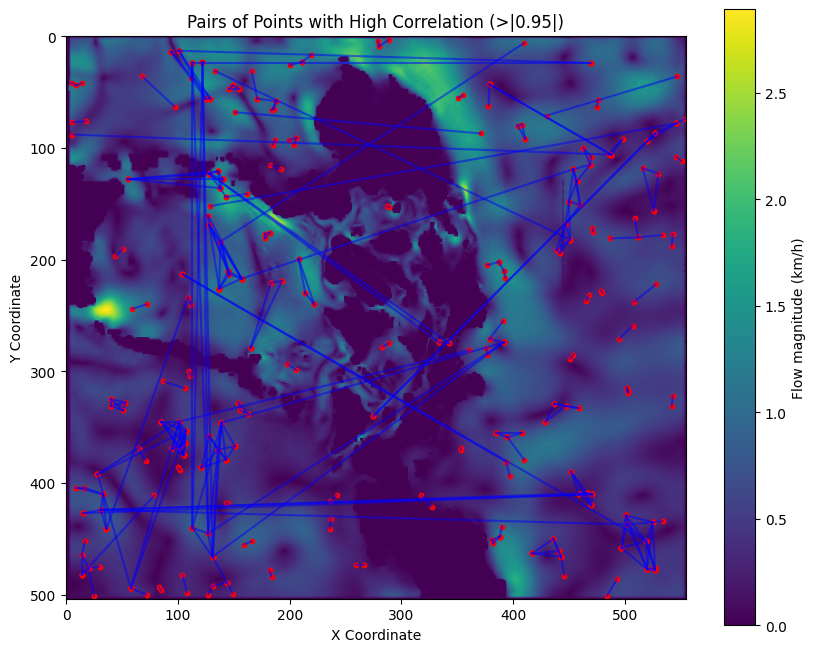

In [15]:
# Plot all high correlation pairs
plt.figure(figsize=(10, 8))
plt.imshow(np.sqrt(us[0]**2 + vs[0]**2), cmap='viridis')
plt.colorbar(label='Flow magnitude (km/h)')

for corr, pt1, pt2 in high_correlations:
    plt.scatter([pt1[1], pt2[1]], [pt1[0], pt2[0]], c='red', s=10)  # Red dots for correlated points
    plt.plot([pt1[1], pt2[1]], [pt1[0], pt2[0]], c='blue', alpha=0.5)  # Blue line connecting correlated points

plt.title(f"Pairs of Points with High Correlation (>|{high_corr_threshold}|)")
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

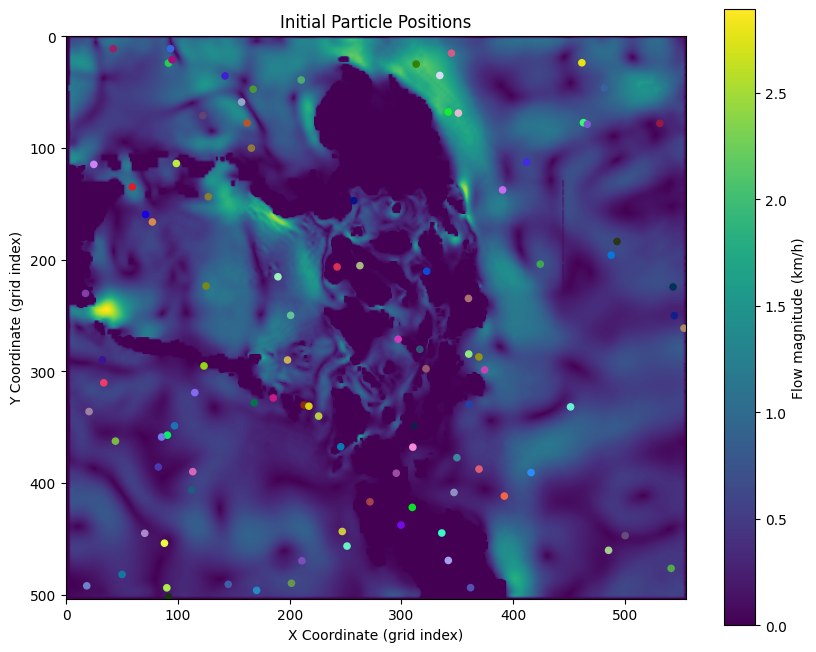

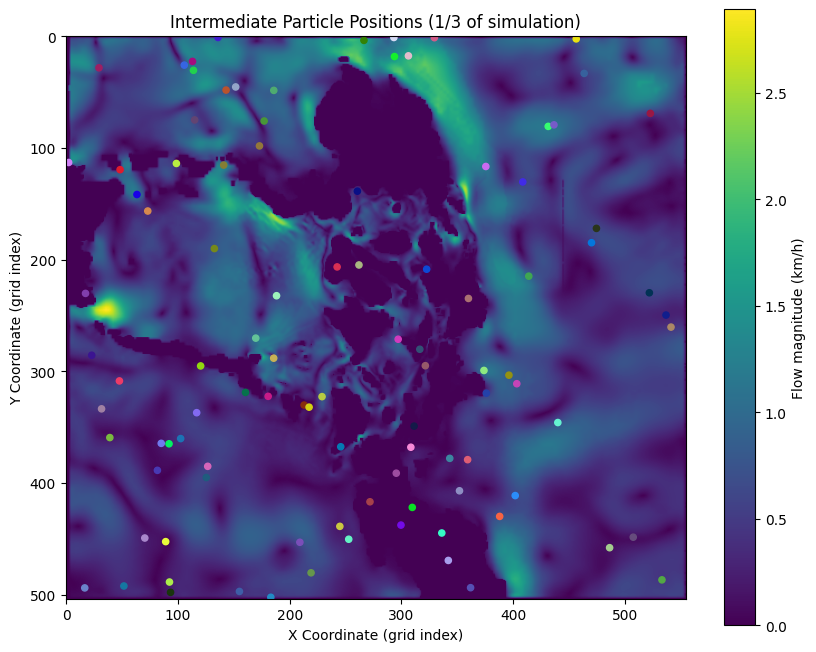

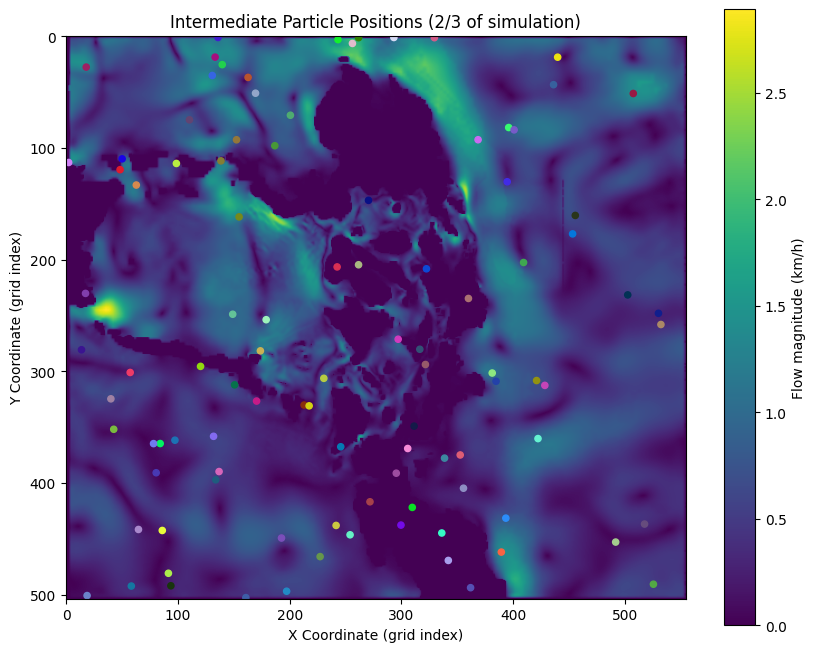

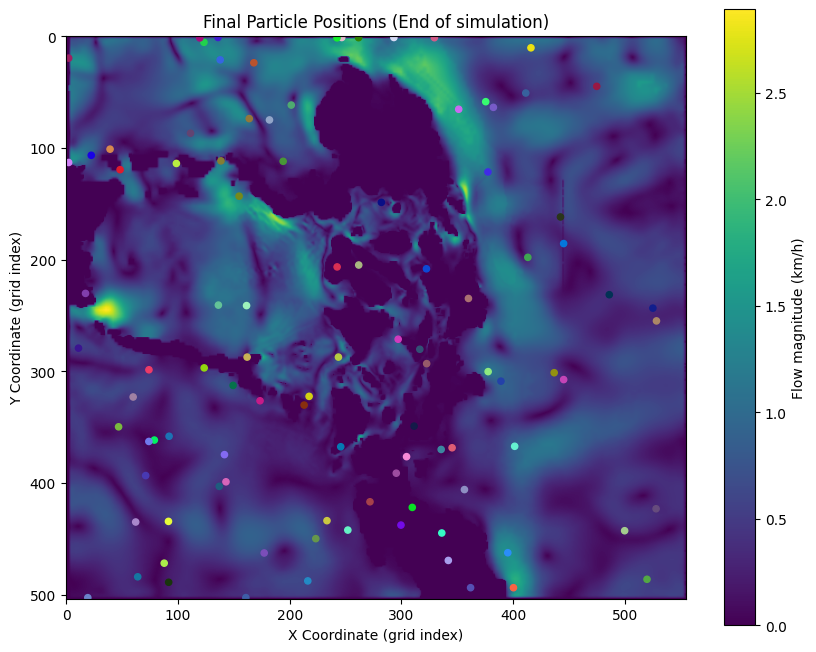

In [17]:
# Grid and time parameters
grid_spacing_km = 3  # Grid spacing in kilometers
time_step_hours = 3  # Time step in hours
total_hours = 300  # Total simulation time in hours
num_time_steps = total_hours // time_step_hours  # Number of time steps to simulate

# Initialize particle positions randomly across the entire map
num_particles = 100  # Number of particles to simulate
max_x, max_y = us.shape[2], us.shape[1]  # Max grid indices

particles = np.array([(random.uniform(0, max_x - 1), random.uniform(0, max_y - 1)) for _ in range(num_particles)])

# Initialize colors for each particle for plotting
particle_colors = np.random.rand(num_particles, 3)

# Store initial positions for plotting later
initial_positions = particles.copy()

# Prepare to store intermediate states for plotting
intermediate_positions_1 = None
intermediate_positions_2 = None

# Simulate particle movement over time
for t in range(num_time_steps):
    # Compute the time index corresponding to the current time step
    time_index = t % 100  # Loop back to start if we exceed available time steps

    # Update particle positions
    for i, (x, y) in enumerate(particles):
        # Find the nearest grid point to the particle's current position
        grid_x, grid_y = int(round(x)), int(round(y))

        # Get the velocity components from the grid at the nearest grid point
        u_velocity = us[time_index, grid_y, grid_x]
        v_velocity = vs[time_index, grid_y, grid_x]

        # Update positions based on the velocity and time step
        new_x = x + (u_velocity * time_step_hours) / grid_spacing_km
        new_y = y + (v_velocity * time_step_hours) / grid_spacing_km

        # Ensure particles stay within the grid bounds
        new_x = min(max(new_x, 0), max_x - 1)
        new_y = min(max(new_y, 0), max_y - 1)

        particles[i] = (new_x, new_y)

    # Store positions at intermediate states for plotting
    if t == num_time_steps // 3:
        intermediate_positions_1 = particles.copy()
    elif t == 2 * num_time_steps // 3:
        intermediate_positions_2 = particles.copy()

# Store final positions for plotting
final_positions = particles

# Plotting functions for different states
def plot_particles(positions, title):
    plt.figure(figsize=(10, 8))
    plt.imshow(np.sqrt(us[0]**2 + vs[0]**2), cmap='viridis')
    plt.colorbar(label='Flow magnitude (km/h)')
    plt.scatter(positions[:, 0], positions[:, 1], c=particle_colors, s=20)
    plt.title(title)
    plt.xlabel('X Coordinate (grid index)')
    plt.ylabel('Y Coordinate (grid index)')
    plt.show()

# Plot initial state
plot_particles(initial_positions, "Initial Particle Positions")

# Plot intermediate state 1
plot_particles(intermediate_positions_1, "Intermediate Particle Positions (1/3 of simulation)")

# Plot intermediate state 2
plot_particles(intermediate_positions_2, "Intermediate Particle Positions (2/3 of simulation)")

# Plot final state
plot_particles(final_positions, "Final Particle Positions (End of simulation)")

Positions stored for 48 hours at step 16.
Positions stored for 72 hours at step 24.


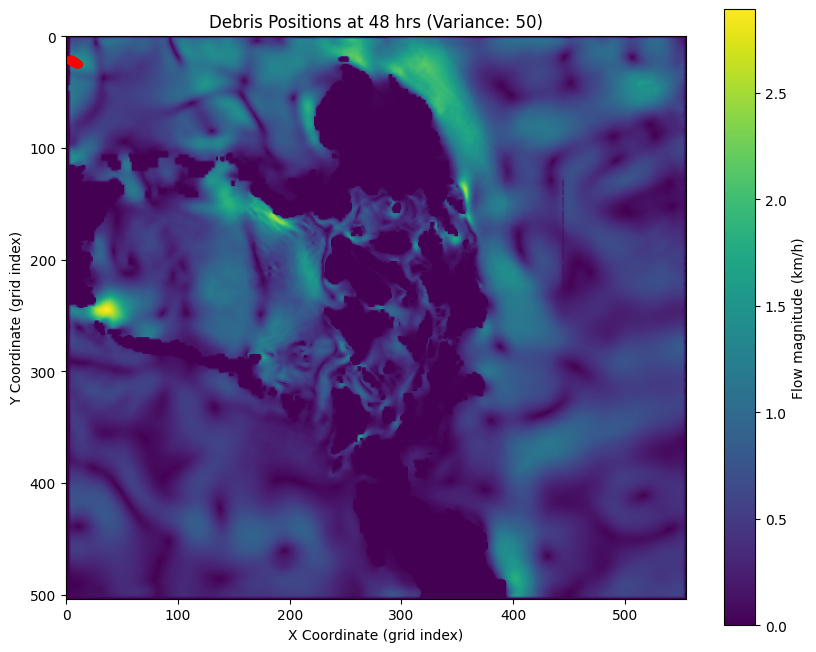

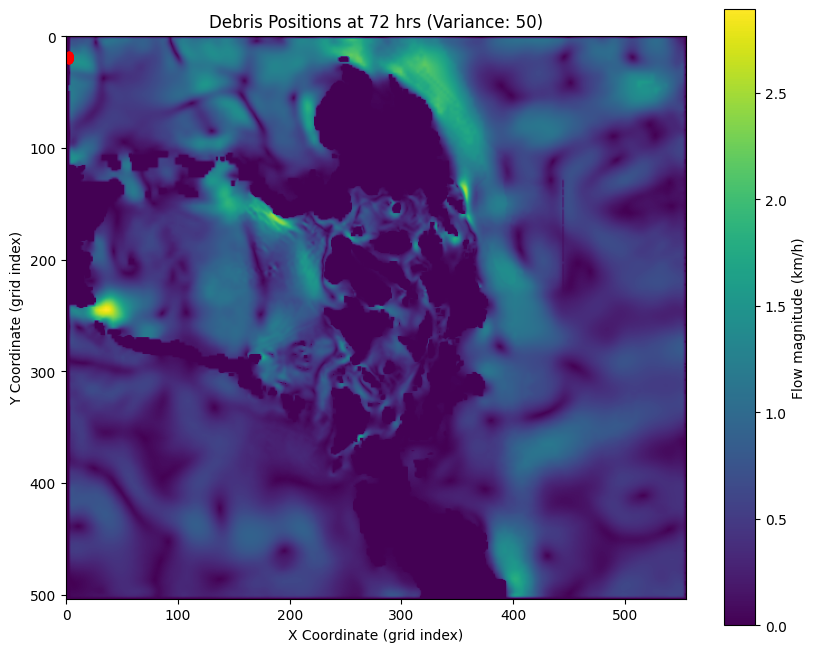

TypeError: 'NoneType' object is not subscriptable

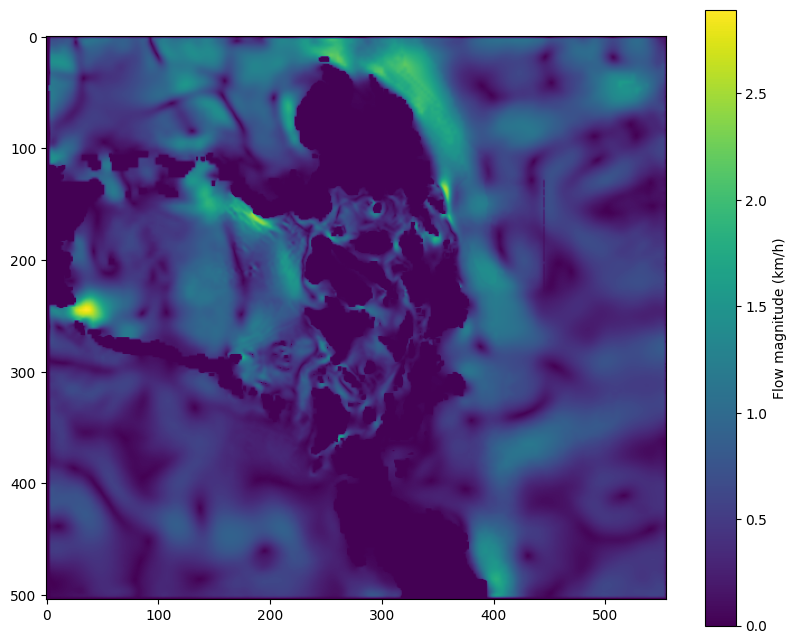

In [21]:
# Grid and time parameters
grid_spacing_km = 3  # Grid spacing in kilometers
time_step_hours = 3  # Time step in hours
max_x, max_y = 555, 504  # Assuming maximum indices from problem statement

# Function to simulate debris movement for a given variance
def simulate_debris_movement(mean_position, variance, num_particles, num_time_steps):
    # Initialize particle positions based on a Gaussian distribution
    particles = np.random.multivariate_normal(mean_position, variance * np.eye(2), num_particles)
    particles /= grid_spacing_km  # Convert to grid indices
    
    # Initialize positions to None
    positions_48hrs = None
    positions_72hrs = None
    positions_120hrs = None
    
    for t in range(num_time_steps):
        # Time index for current time step in flow data
        time_index = t % 100

        # Update particle positions
        for i, (x, y) in enumerate(particles):
            # Ensure the particle is within grid bounds
            grid_x, grid_y = int(round(x)), int(round(y))
            grid_x = np.clip(grid_x, 0, max_x - 1)
            grid_y = np.clip(grid_y, 0, max_y - 1)

            # Get velocity components at current grid point
            u_velocity = us[time_index, grid_y, grid_x]
            v_velocity = vs[time_index, grid_y, grid_x]

            # Update positions
            new_x = x + (u_velocity * time_step_hours) / grid_spacing_km
            new_y = y + (v_velocity * time_step_hours) / grid_spacing_km

            # Ensure new positions are within grid bounds
            new_x = min(max(new_x, 0), max_x - 1)
            new_y = min(max(new_y, 0), max_y - 1)
            particles[i] = (new_x, new_y)

        # Store positions at specified times
        if t == 48 // time_step_hours:
            positions_48hrs = particles.copy()
            print(f"Positions stored for 48 hours at step {t}.")
        elif t == 72 // time_step_hours:
            positions_72hrs = particles.copy()
            print(f"Positions stored for 72 hours at step {t}.")
        elif t == 120 // time_step_hours:
            positions_120hrs = particles.copy()
            print(f"Positions stored for 120 hours at step {t}.")
    
    return positions_48hrs, positions_72hrs, positions_120hrs


# Function to plot particle positions
def plot_positions(positions, title):
    plt.figure(figsize=(10, 8))
    plt.imshow(np.sqrt(us[0]**2 + vs[0]**2), cmap='viridis')
    plt.colorbar(label='Flow magnitude (km/h)')
    plt.scatter(positions[:, 0], positions[:, 1], c='red', s=20, alpha=0.7)
    plt.title(title)
    plt.xlabel('X Coordinate (grid index)')
    plt.ylabel('Y Coordinate (grid index)')
    plt.show()

# Set up mean position and number of particles
mean_position_km = np.array([100, 350])  # Mean position in km
mean_position = mean_position_km / grid_spacing_km  # Convert to grid indices
num_particles = 500  # Number of particles to simulate

# Variances to test
variances = [50, 200]  # Variance values for Gaussian distribution

# Simulate and plot for each variance
for var in variances:
    var_grid = var / (grid_spacing_km ** 2)  # Convert variance to grid scale
    pos_48, pos_72, pos_120 = simulate_debris_movement(mean_position, var_grid, num_particles, 120 // time_step_hours)
    
    plot_positions(pos_48, f"Debris Positions at 48 hrs (Variance: {var})")
    plot_positions(pos_72, f"Debris Positions at 72 hrs (Variance: {var})")
    plot_positions(pos_120, f"Debris Positions at 120 hrs (Variance: {var})")